In [1]:
%matplotlib inline
from matplotlib.pylab import plt

import pandas as pd
import numpy as np

# Let's look at some data with seasonality + trend

In [2]:
air_passengers = pd.read_csv("data/AirPassengers.csv", header = 0, parse_dates = [0], names = ['Month', 'Passengers'], index_col = 0)

### How does it make sense to structure this data?

In [3]:
air_passengers.head()

Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121

In [4]:
air_passengers = air_passengers.to_period()

In [5]:
air_passengers['1950-06-01':'1950-06-03']

Passengers
Month              
1950-06         149

### How can we get a sense of this time series?

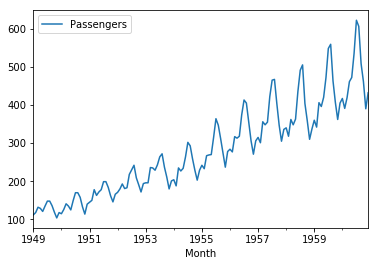

In [6]:
air_passengers.plot()

In [ ]:
# first thing we look at for a time series when we want to use common analysis techniques:
# is it stationary: constant mean, constant variance, autocovariance does not depend on time

### Have we got a time independent mean?

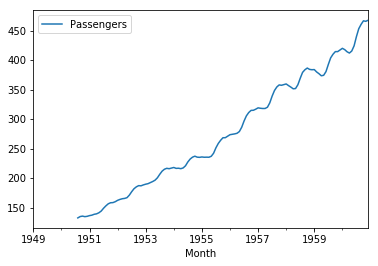

In [7]:
# first test, informally, plot the moving average
air_passengers.rolling(window = 20).mean().plot()

### Have we got a time independent variance?

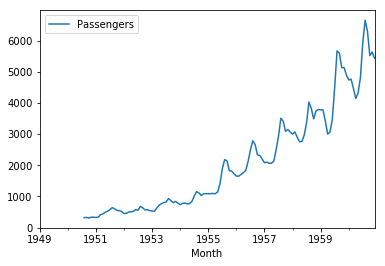

In [8]:
# Can you plot the variance?
air_passengers.rolling(window = 20).var().plot()

### How does sizing your window affect your results?

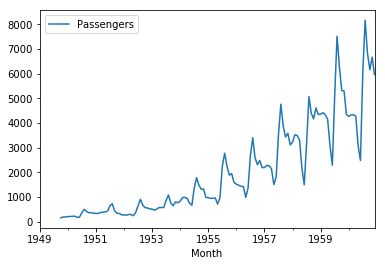

In [9]:
# Can you plot the variance?
air_passengers.rolling(window = 10).var().plot()

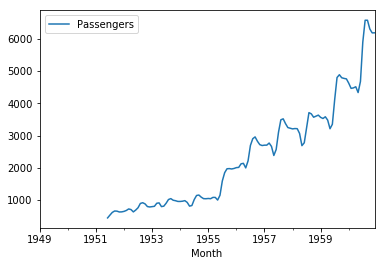

In [10]:
# Can you plot the variance?
air_passengers.rolling(window = 30).var().plot()

### How should you size your window?

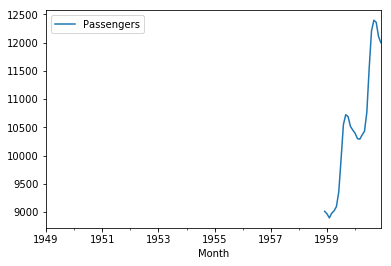

In [17]:
air_passengers.rolling(window = 120).var().plot()
# 10 years

# More formally testing for stationarity

In [18]:
# next more formally apply the Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(air_passengers.Passengers, autolag = 'AIC')

In [20]:
dftest
# What do these numbers mean?
# 0.81536887920604462 = test statistic
# 0.99188024343764092 = pvalue
# 13 = used lags
# 130 = observations used for ADF regression and calc of critical values
# {1%, 10%, 5% values} = critical values at the 1%, 10% and 5% levels
# 996.69293083901903 = maximized information criterian for autolag = 'AIC'

(0.81536887920604462,
 0.99188024343764092,
 13,
 130,
 {'1%': -3.4816817173418295,
  '10%': -2.5787700591715979,
  '5%': -2.8840418343195267},
 996.69293083901903)

### Can we write a function to output these #s sensibly?
Hint: check out statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.stattools.adfuller.html

In [25]:
print('test statistic: ', dftest[0])
print('p value: ', dftest[1])
print('used lags: ', dftest[2])
print('observations: ', dftest[3])
print('critical values: ', dftest[4])
print('autolag: ', dftest[5])

test statistic:  0.815368879206
p value:  0.991880243438
used lags:  13
observations:  130
critical values:  {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.5787700591715979}
autolag:  996.692930839


### Are we stuck not doing any analysis now that our time series is not stationary?

Hint: no.
How can we make it stationary?
Why is it non-stationary (2 reasons)

In [31]:
# non-stationary because of the repeating cycle and upward trend

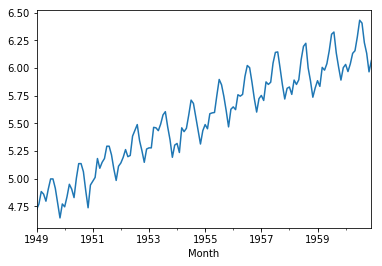

In [26]:
# First let's get rid of the 'trend' contribution to the time series not being stationary
# One method to get rid of a trend is to do a power or log transformation that punishes larger values
# more than smaller values
log_passengers = air_passengers.Passengers.apply(lambda x: np.log(x))
log_passengers.plot()

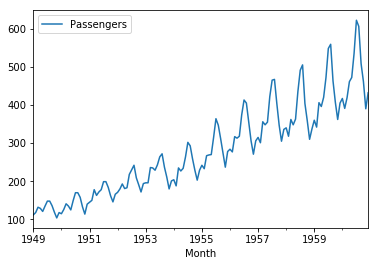

In [28]:
# This reduces the variance in variance as opposed to the original trend
air_passengers.plot()

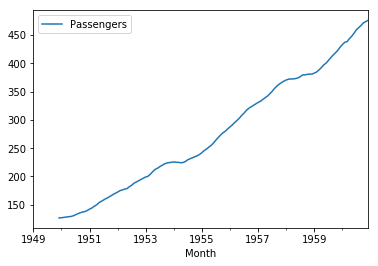

In [29]:
# However there is still a trend we need to remove
# Let's calculate a rolling mean
# Experiment with window size
air_passengers.rolling(window = 12).mean().plot()

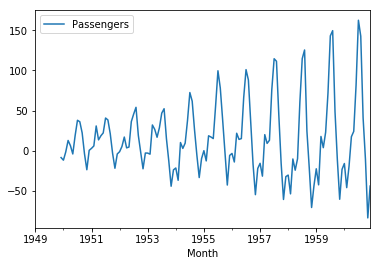

In [30]:
# What if we subtract this rolling mean from the original series?
rolling_mean = air_passengers.rolling(window = 12).mean()
passengers_detrended = air_passengers - rolling_mean
passengers_detrended.plot()

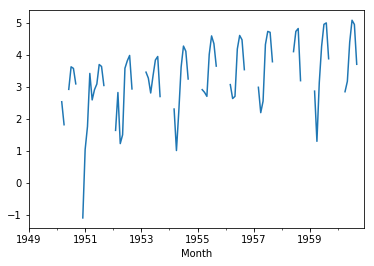

In [34]:
# Exercise: try detrending after taking the log. How does that look?
rolling_mean = air_passengers.rolling(window = 12).mean()
passengers_detrended = air_passengers - rolling_mean
log_detrended2 = passengers_detrended.Passengers.apply(lambda x: np.log(x))
log_detrended2.plot()

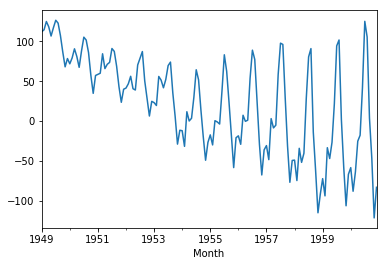

In [35]:
# Now let's use a regression rather than a rolling mean to detrend
from statsmodels.regression.linear_model import OLS
model = OLS(air_passengers.Passengers.values, list(range(len(air_passengers.values))))
result = model.fit()
result.params
fit = pd.Series(result.predict(list(range(len(air_passengers.values)))), index = air_passengers.index)

passengers_detrended = air_passengers.Passengers - fit
passengers_detrended.plot()

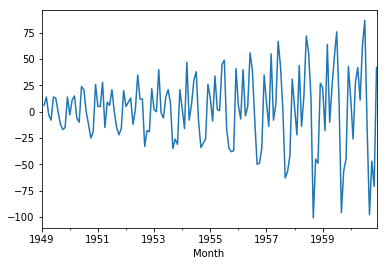

In [36]:
# Now let's take a look at seasonality
(air_passengers.Passengers - air_passengers.Passengers.shift()).plot()

In [38]:
# When might a rolling average work better/worse than a regression?
# depends on the importance of recent data points vs. all data points

In [37]:
# How might we be able to eliminate both trend and seasonality?
# Looking for two answers...
# differencing and decomposing

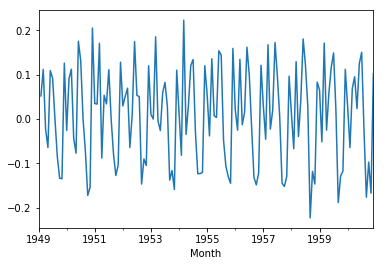

In [39]:
# One common technique is differencing, let's start with log_passengers
log_passengers_diff = log_passengers - log_passengers.shift()
log_passengers_diff.plot()

In [40]:
# Let's again test for stationarity with a gut level check.
# And let's write a function to do it since this seems like something we'll have to do a lot
# check adfuller results; if dftest[0] > dftest[4]['5%'], time series is non-stationary

In [41]:
log_passengers = log_passengers.to_timestamp()

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose

log_passengers.interpolate(inplace = True)
decomposition = seasonal_decompose(log_passengers)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\filters\filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


In [43]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

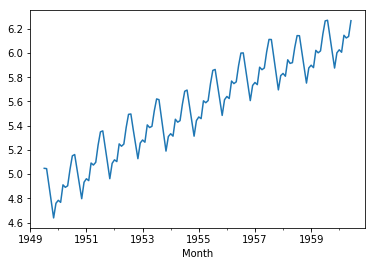

In [44]:
(seasonal+trend).plot()

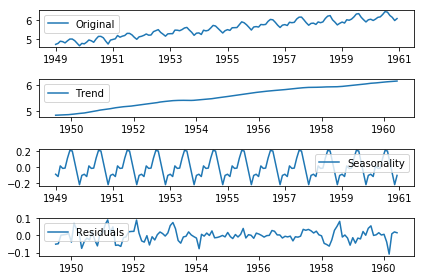

In [45]:

plt.subplot(411)
plt.plot(log_passengers, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()